In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc

import joblib


#Loadind Dataset

In [4]:
df = pd.read_csv("adult_data.csv")
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


#Initial Data Exploration

In [5]:
print(f"Dataset Shape : {df.shape}")
num_of_raw_bf = df.shape[0]
df.info()

Dataset Shape : (48842, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [6]:
print(f"Number of null value :\n{df.isnull().sum()}")
print(f"Number of duplicated value {df[df.duplicated()].shape[0]}")

Number of null value :
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64
Number of duplicated value 29


In [7]:
#### Data Cleaning
df = df.replace("?", np.nan)
df = df.dropna()
df = df.drop_duplicates()
num_of_raw_af = df.shape[0]
print("New Shape after cleaning :", df.shape)
print("Number of rows dropped :", num_of_raw_bf - num_of_raw_af)
print("Number of duplicated value after dropped :",df[df.duplicated()].shape[0])


New Shape after cleaning : (45194, 15)
Number of rows dropped : 3648
Number of duplicated value after dropped : 0


#Sperating Features and Target

In [8]:
df['income']

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K
...,...
48836,<=50K.
48837,<=50K.
48839,<=50K.
48840,<=50K.


In [9]:
df['income'] = df['income'].str.strip().str.replace('.', '', regex=False)
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

In [10]:
X = df.drop("income",axis=1)
y = df["income"]

In [11]:
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

print("Categorical Columns:", cat_cols)
print("Numerical Columns:", num_cols)

Categorical Columns: Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')
Numerical Columns: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',OneHotEncoder(drop='first'), cat_cols),
        ('num','passthrough', num_cols)
    ]
)
X_processed = preprocessor.fit_transform(X)


#Splitting the Data

In [13]:
# split : 70% Train - 15% Val - 15% Test

X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y, test_size=0.30, random_state=42, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True
)


#Scaling Numerical Features

In [14]:
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)




#Training Models

In [15]:
lr = LogisticRegression(max_iter=1000,random_state=42,)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_val_pred = lr.predict(X_val_scaled)





In [16]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
rf_val_pred  = rf.predict(X_val_scaled)




In [17]:
svm = SVC(kernel= 'rbf',random_state=42, C=1.0, gamma='scale'
)
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)
svm_val_pred = svm.predict(X_val_scaled)



In [18]:
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)
xgb_val_pred = xgb.predict(X_val_scaled)

joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(xgb, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

#Evaluation Function

In [19]:
def evaluate_model(model_name, y, y_hat):
  print(f"-----------{model_name}---------")
  print(f"Accuracy: {accuracy_score(y, y_hat)}")
  print(f"Precision: {precision_score(y, y_hat,pos_label=1)}")
  print(f"Recall: {recall_score(y, y_hat, pos_label=1)}")
  print(f"F1 Score: {f1_score(y, y_hat, pos_label= 1)}")
  print("\nClassification Report:")
  print(classification_report(y, y_hat))

#Display Model Performance

In [20]:
print("\n========== VALIDATION RESULTS ==========\n")

evaluate_model("Logistic Regression - VAL", y_val, lr_val_pred)
evaluate_model("Random Forest - VAL", y_val, rf_val_pred)
evaluate_model("SVM - VAL", y_val, svm_val_pred)
evaluate_model("XGBoost - VAL", y_val, xgb_val_pred)


========== VALIDATION RESULTS ==========

-----------Logistic Regression - VAL---------
Accuracy: 0.8514530166691252
Precision: 0.7360226468506723
Recall: 0.6212664277180406
F1 Score: 0.6737933268545514

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5105
           1       0.74      0.62      0.67      1674

    accuracy                           0.85      6779
   macro avg       0.81      0.77      0.79      6779
weighted avg       0.85      0.85      0.85      6779

-----------Random Forest - VAL---------
Accuracy: 0.8482077002507744
Precision: 0.718052738336714
Recall: 0.6344086021505376
F1 Score: 0.6736441484300666

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5105
           1       0.72      0.63      0.67      1674

    accuracy                           0.85      6779
   macro avg       0.80      0.78      0.79      

In [21]:
print("\n========== Test RESULTS ==========\n")

evaluate_model("Logistic Regression", y_test, lr_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("SVM", y_test, svm_pred)
evaluate_model("XGBoost", y_test, xgb_pred)



========== Test RESULTS ==========

-----------Logistic Regression---------
Accuracy: 0.8452802359882006
Precision: 0.7236111111111111
Recall: 0.6154754873006497
F1 Score: 0.6651771465049473

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5087
           1       0.72      0.62      0.67      1693

    accuracy                           0.85      6780
   macro avg       0.80      0.77      0.78      6780
weighted avg       0.84      0.85      0.84      6780

-----------Random Forest---------
Accuracy: 0.852212389380531
Precision: 0.7329737019554956
Recall: 0.642055522740697
F1 Score: 0.6845088161209067

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      5087
           1       0.73      0.64      0.68      1693

    accuracy                           0.85      6780
   macro avg       0.81      0.78      0.79      6780
weighted avg  

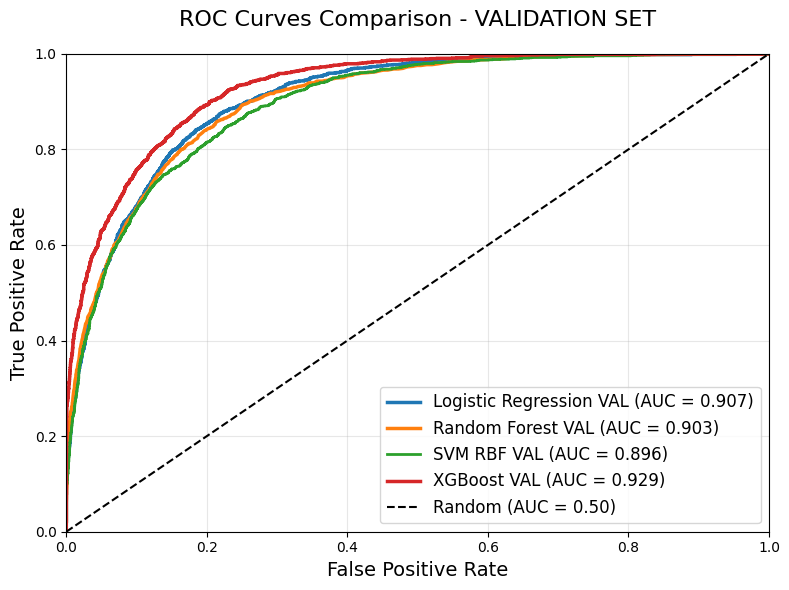

In [24]:
# ===== Validation Probabilities for ROC =====

lr_val_prob  = lr.predict_proba(X_val_scaled)[:, 1]
rf_val_prob  = rf.predict_proba(X_val_scaled)[:, 1]
svm_val_dec  = svm.decision_function(X_val_scaled)
xgb_val_prob = xgb.predict_proba(X_val_scaled)[:, 1]


# ===== ROC Metrics for Validation =====

fpr1_v, tpr1_v, _ = roc_curve(y_val, lr_val_prob)
roc_auc1_v = auc(fpr1_v, tpr1_v)

fpr2_v, tpr2_v, _ = roc_curve(y_val, rf_val_prob)
roc_auc2_v = auc(fpr2_v, tpr2_v)

fpr3_v, tpr3_v, _ = roc_curve(y_val, svm_val_dec)
roc_auc3_v = auc(fpr3_v, tpr3_v)

fpr4_v, tpr4_v, _ = roc_curve(y_val, xgb_val_prob)
roc_auc4_v = auc(fpr4_v, tpr4_v)


# ===== ROC Curve Plot for VALIDATION SET =====

plt.figure(figsize=(8, 6))

plt.plot(fpr1_v, tpr1_v, label=f'Logistic Regression VAL (AUC = {roc_auc1_v:.3f})', linewidth=2.5)
plt.plot(fpr2_v, tpr2_v, label=f'Random Forest VAL (AUC = {roc_auc2_v:.3f})', linewidth=2.5)
plt.plot(fpr3_v, tpr3_v, label=f'SVM RBF VAL (AUC = {roc_auc3_v:.3f})', linewidth=2)
plt.plot(fpr4_v, tpr4_v, label=f'XGBoost VAL (AUC = {roc_auc4_v:.3f})', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves Comparison - VALIDATION SET', fontsize=16, pad=20)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()



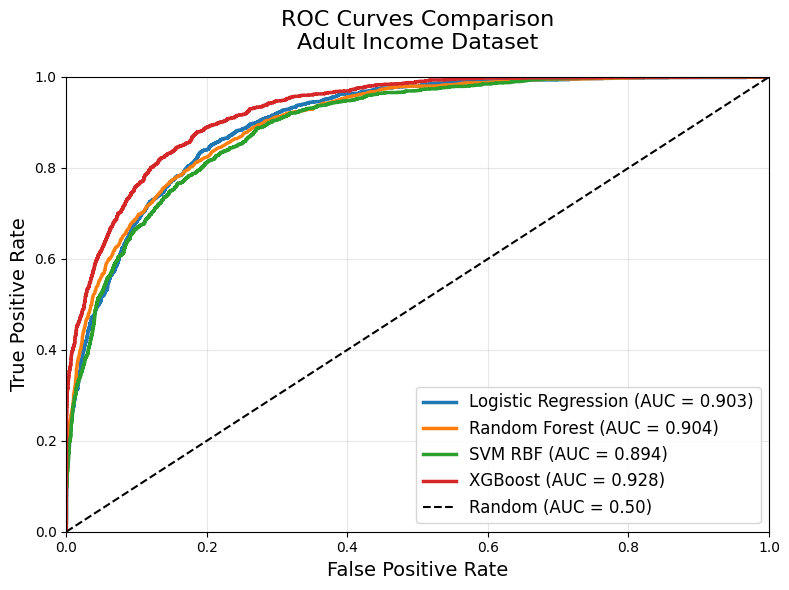

In [22]:
y_test_numeric = y_test

lr_prob = lr.predict_proba(X_test_scaled)[:, 1]
rf_prob = rf.predict_proba(X_test_scaled)[:, 1]
svm_decision = svm.decision_function(X_test_scaled)
xgb_prob = xgb.predict_proba(X_test_scaled)[:, 1]

# --- ROC Curves ---
fpr1, tpr1, _ = roc_curve(y_test_numeric, lr_prob)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test_numeric, rf_prob)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test_numeric, svm_decision)
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(y_test_numeric, xgb_prob)
roc_auc4 = auc(fpr4, tpr4)


plt.figure(figsize=(8, 6))

plt.plot(fpr1, tpr1, label=f'Logistic Regression (AUC = {roc_auc1:.3f})', linewidth=2.5)
plt.plot(fpr2, tpr2, label=f'Random Forest (AUC = {roc_auc2:.3f})', linewidth=2.5)
plt.plot(fpr3, tpr3, label=f'SVM RBF (AUC = {roc_auc3:.3f})', linewidth=2.5)
plt.plot(fpr4, tpr4, label=f'XGBoost (AUC = {roc_auc4:.3f})', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves Comparison\nAdult Income Dataset', fontsize=16, pad=20)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


#Conclusion / Results Summary

##  **Validation vs Test**


| Model | Val Accuracy | Test Accuracy | Difference |
|--------|---------------|----------------|-------------|
| Logistic Regression | 0.8514 | 0.8453 |  0.006 |
| Random Forest | 0.8482 | 0.8522 |  0.004 |
| SVM | 0.8482 | 0.8444 |  0.004 |
| XGBoost | 0.8689 | 0.8693 |  0.0004 |



---

##  Model Performance Comparison (**Test Set**)
Test Set:

| Model | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-score (Class 1) |
|--------|-----------|----------------------|-------------------|--------------------|
| Logistic Regression | 0.845 | 0.724 | 0.615 | 0.665 |
| Random Forest | 0.852 | 0.733 | 0.642 | 0.684 |
| SVM | 0.844 | 0.752 | 0.563 | 0.644 |
|  XGBoost |  0.869 |  0.778 |  0.667 |  0.718 |

---

##  Final Conclusion

The **XGBoost** model is the best among all models because it:

- Achieves the highest accuracy
- Highest precision
- Highest recall rate
- Highest F1 score
- Demonstrates excellent stability between validation and testing without overfitting

Therefore, **XGBoost** was adopted as the final production model.
